In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

class PTDistilBertClassifier:
    def __init__(self, num_classes: int, model_name: str = "distilbert-base-uncased"):
        self.num_classes = num_classes
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        self.model = DistilBertForSequenceClassification.from_pretrained(
            model_name, num_labels=num_classes
        )
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def encode(self, texts, labels=None, max_length=None):
        max_length = max_length or self.tokenizer.model_max_length
        enc = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        if labels is not None:
            enc["labels"] = torch.tensor(labels, dtype=torch.long)
        return enc

    def fit(
        self, texts, labels,
        epochs=3, lr=3e-5, batch_size=8, train_ratio=0.8,
        model_save_path: str = None, load_path: str = None
    ):
        # Load model weights if specified
        if load_path and os.path.exists(load_path):
            print(f"Loading model weights from {load_path}")
            self.model.load_state_dict(torch.load(load_path, map_location=self.device))

        # Split data
        x_tr, x_val, y_tr, y_val = train_test_split(
            texts, labels, train_size=train_ratio, stratify=labels, random_state=42
        )

        # DataLoader helper
        def make_loader(x, y, shuffle=True):
            enc = self.encode(x, y)
            ds = TensorDataset(enc["input_ids"], enc["attention_mask"], enc["labels"])
            return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

        train_loader = make_loader(x_tr, y_tr)
        val_loader = make_loader(x_val, y_val, shuffle=False)

        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)

        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            for ids, masks, labs in train_loader:
                ids, masks, labs = [t.to(self.device) for t in (ids, masks, labs)]
                out = self.model(input_ids=ids, attention_mask=masks, labels=labs)
                loss = out.loss
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss.item()

            # --- Validation ---
            self.model.eval()
            val_loss = 0
            all_preds, all_probs, all_labels = [], [], []
            with torch.no_grad():
                for ids, masks, labs in val_loader:
                    ids, masks, labs = [t.to(self.device) for t in (ids, masks, labs)]
                    out = self.model(input_ids=ids, attention_mask=masks, labels=labs)
                    val_loss += out.loss.item()
                    logits = out.logits
                    probs = F.softmax(logits, dim=-1).cpu().numpy()
                    preds = probs.argmax(axis=1)
                    all_probs.append(probs)
                    all_preds.extend(preds)
                    all_labels.extend(labs.cpu().numpy())

            all_probs = np.vstack(all_probs)
            acc = accuracy_score(all_labels, all_preds)
            f1 = f1_score(all_labels, all_preds, average="macro")
            try:
                roc_auc = roc_auc_score(all_labels, all_probs, average="macro", multi_class="ovr")
            except ValueError:
                roc_auc = None

            print(f"[Epoch {epoch+1}] "
                f"train_loss={total_loss/len(train_loader):.4f} | "
                f"val_loss={val_loss/len(val_loader):.4f} | "
                f"val_acc={acc:.4f} | f1_macro={f1:.4f} | roc_auc_macro={roc_auc}")

        # Save model
        if model_save_path:
            os.makedirs(model_save_path, exist_ok=True)
            base_path = os.path.join(model_save_path, "model.pt")
            
            if os.path.exists(base_path):
                # Tìm version tiếp theo chưa tồn tại
                version = 1
                while True:
                    versioned_path = os.path.join(model_save_path, f"model_v{version}.pt")
                    if not os.path.exists(versioned_path):
                        save_path = versioned_path
                        break
                    version += 1
            else:
                save_path = base_path

            torch.save(self.model.state_dict(), save_path)
            print(f"Model saved to {save_path}")

    def predict_proba(self, texts, batch_size: int = 16):
        self.model.eval()
        enc = self.encode(texts)
        ds = TensorDataset(enc["input_ids"], enc["attention_mask"])
        loader = DataLoader(ds, batch_size=batch_size)
        probs_list = []
        with torch.no_grad():
            for ids, masks in loader:
                ids, masks = ids.to(self.device), masks.to(self.device)
                logits = self.model(input_ids=ids, attention_mask=masks).logits
                probs = F.softmax(logits, dim=-1).cpu().numpy()
                if probs.ndim == 1:
                    probs = probs.reshape(1, -1)
                probs_list.append(probs)
        return np.vstack(probs_list)

    def predict(self, texts, batch_size: int = 16):
        probs = self.predict_proba(texts, batch_size)
        return probs.argmax(axis=1)

    def evaluate(self, texts, labels, batch_size: int = 16, class_names=None):
        y_true = np.array(labels)
        probs = self.predict_proba(texts, batch_size)
        y_pred = probs.argmax(axis=1)

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average="macro")

        try:
            roc_auc = roc_auc_score(y_true, probs, average="macro", multi_class="ovr")
        except ValueError:
            roc_auc = None

        cm = confusion_matrix(y_true, y_pred)

        # Plot confusion matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names if class_names else np.unique(y_true),
                    yticklabels=class_names if class_names else np.unique(y_true))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()

        return {
            "accuracy": acc,
            "f1_macro": f1,
            "roc_auc_macro": roc_auc,
            "confusion_matrix": cm.tolist(),
            
        }


In [11]:
import pandas as pd
pd.set_option('display.max_columns', None) 
# Đọc dữ liệu
df_train = pd.read_csv(r"/home/minhle/Downloads/train_data.csv")
df_val = pd.read_csv(r"/home/minhle/Downloads/val_data.csv")
df = pd.concat([df_train, df_val], ignore_index=True)
df = df[['review_text', 'sentiment']]
df = df.dropna()
df["sentiment"] = df["sentiment"].astype(int)

texts = df["review_text"].tolist()
labels = df["sentiment"].tolist()


In [13]:
classifier = PTDistilBertClassifier(num_classes=3)

classifier.fit(
    texts=texts,
    labels=labels,
    epochs=1,
    lr=2e-5,
    batch_size=32,
    train_ratio=0.8,
    model_save_path="./MinhLe",
    load_path="./MinhLe/model.pt"  # <- load từ đây
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Epoch 1] train_loss=0.2812 | val_loss=0.2258 | val_acc=0.9096 | f1_macro=0.7311 | roc_auc_macro=0.961385034705931
Model saved to ./MinhLe/model.pt


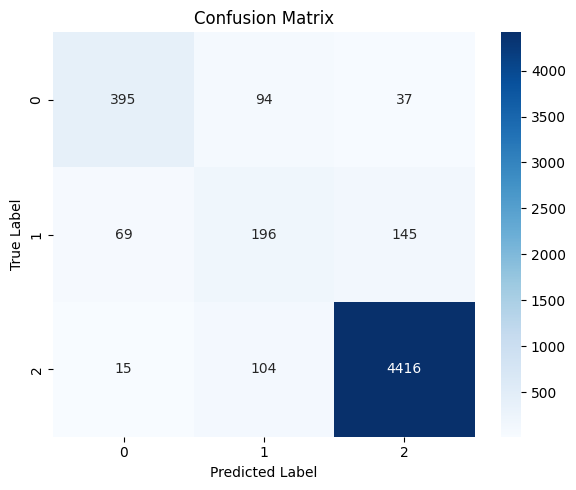

{'accuracy': 0.9151891793090843, 'f1_macro': 0.7468914778637924, 'roc_auc_macro': np.float64(0.9631966068055613), 'confusion_matrix': [[395, 94, 37], [69, 196, 145], [15, 104, 4416]]}


In [14]:
df_test = pd.read_csv(r"/home/minhle/Downloads/test_data.csv")
df_test = df_test[['review_text', 'sentiment']]
df_test = df_test.dropna()
df_test["sentiment"] = df_test["sentiment"].astype(int)

texts = df_test["review_text"].tolist()
labels = df_test["sentiment"].tolist()
x_test = texts
y_test = labels

results = classifier.evaluate(x_test, y_test)
print(results)


In [7]:
samples = [
    "This product works wonders on my skin.",
    "Not worth the money, didn't help at all."
]
probs = classifier.predict_proba(samples)
preds = classifier.predict(samples)

for text, pred, prob in zip(samples, preds, probs):
    print(f"{text} --> predicted={pred}, probs={prob}")


This product works wonders on my skin. --> predicted=2, probs=[1.7858448e-04 1.1551783e-03 9.9866629e-01]
Not worth the money, didn't help at all. --> predicted=0, probs=[0.96312016 0.0340411  0.00283879]
